In [4]:
# 
import numpy as np
import scipy.stats
import scipy
import matplotlib.pyplot as plt


In [44]:
def bias_corr_historical_normal(data_grid_obs,data_grid_hist):

    var_data_obs = data_grid_obs
    var_data_hist = data_grid_hist

    var_data_obs[np.isnan(var_data_obs)]=np.nanmean(var_data_obs)
    var_data_hist[np.isnan(var_data_hist)]=np.nanmean(var_data_hist)

    bias_corr=np.zeros(var_data_hist.shape[0]);


    mu,sig = scipy.stats.norm.fit(var_data_hist)

    cdf = scipy.stats.norm.cdf(data_grid_hist,loc=mu,scale=sig)

    omu,osig = scipy.stats.norm.fit(var_data_obs)

    bias_corr=scipy.stats.norm.ppf(cdf,loc=omu,scale=osig)

    return bias_corr


def bias_corr_historical_gamma_zeros(data_grid_obs,data_grid_hist):
    var_data_obs = data_grid_obs
    var_data_hist = data_grid_hist

    var_data_obs[var_data_obs<0]=0
    var_data_hist[var_data_hist<0]=0

    var_data_obs[np.isnan(var_data_obs)]=0
    var_data_hist[np.isnan(var_data_hist)]=0

    bias_corr=np.zeros(var_data_hist.shape[0]);

    data=var_data_hist
    data_non_zeros=(data[data!=0])
    count_zeros=(data[data==0].shape[0])
    count_total=(data.shape[0])
    p_zeros=count_zeros/count_total
    fita,fitloc,fitscale = scipy.stats.gamma.fit(data_non_zeros,floc=0)
#     print('Mod:',fita,fitloc,fitscale)
    cdf= p_zeros + (1 - p_zeros) * scipy.stats.gamma.cdf(var_data_hist, a=fita,loc=fitloc,scale=fitscale)
    data=var_data_obs
    data_non_zeros=(data[data!=0])
    count_zeros=(data[data==0].shape[0])
    count_total=(data.shape[0])
    p_zeros_imd=count_zeros/count_total
    ofita,ofitloc,ofitscale = scipy.stats.gamma.fit(data_non_zeros,floc=0)
#     print('Obs:',ofita,ofitloc,ofitscale)

#     print(p_zeros,p_zeros_imd)
    for iter in range(cdf.shape[0]):
        cdfi=cdf[iter]
        if cdfi<=p_zeros_imd:
            bias_corr[iter]=0
        else:
            z=(cdfi-p_zeros_imd)/(1-p_zeros_imd)
            bias_corr[iter]=scipy.stats.gamma.ppf(z, a=ofita,loc=ofitloc,scale=ofitscale)

    return bias_corr

def bias_corr_historical_np(data_grid_obs,data_grid_hist):
# np is  non parmetric
    var_data_obs = data_grid_obs
    var_data_hist = data_grid_hist

    var_data_obs[np.isnan(var_data_obs)]=np.nanmean(var_data_obs)
    var_data_hist[np.isnan(var_data_hist)]=np.nanmean(var_data_hist)

    bias_corr=np.zeros(var_data_hist.shape[0]);

    hist = np.histogram(var_data_hist, bins=30)
    hist_dist = scipy.stats.rv_histogram(hist)

    cdf = hist_dist.cdf(data_grid_hist)

    omu,osig = scipy.stats.norm.fit(var_data_obs)
    
    histo = np.histogram(var_data_obs, bins=30)
    hist_disto = scipy.stats.rv_histogram(histo)

    bias_corr=hist_disto.ppf(cdf)

    return bias_corr
import numpy as np
from scipy.stats import percentileofscore
def eQM_replace(ref_dataset, model_present, model_future):
        """
        For each model_future value, get its percentile on the CDF of model_present,
        then ust it to get a value from the model_present.
        returns: downscaled model_present and model_future        
        """
        model_present_corrected = np.zeros(model_present.size)  
        model_future_corrected = np.zeros(model_future.size)

        for ival, model_value in enumerate(model_present):
            percentile = percentileofscore(model_present, model_value)
            model_present_corrected[ival] = np.percentile(ref_dataset, percentile)

        for ival, model_value in enumerate(model_future):
            percentile = percentileofscore(model_present, model_value)
            model_future_corrected[ival] = np.percentile(ref_dataset, percentile)
            
        return model_present_corrected, model_future_corrected

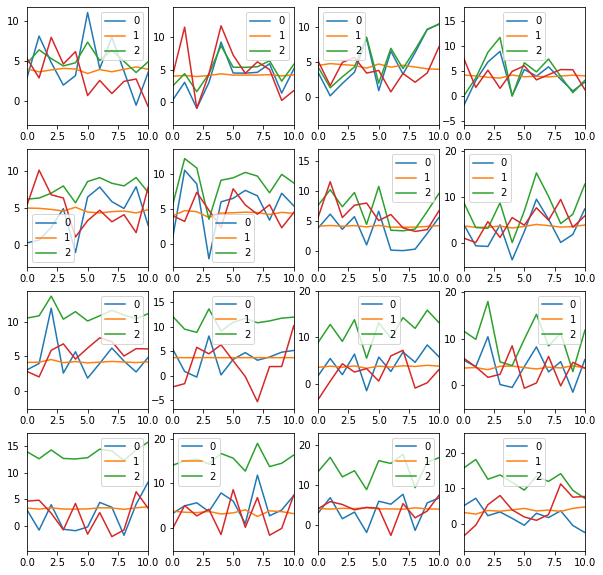

In [152]:
import numpy as np
from sklearn.linear_model import LinearRegression


plt.figure(figsize = (10,10))
itetr=0
for muuu in range(5,15+1,3):
    for siggg in range(1,5):
        itetr=itetr+1
        plt.subplot(4,4,itetr)
        mu = muuu
        sigma = siggg
        sizeN= 100
        theta = sigma *sigma / mu
        k= mu/theta
        data_gamma = scipy.stats.gamma.rvs(a=k, loc=0,scale=theta, size=sizeN)

        data_normal = scipy.stats.norm.rvs(loc=mu,scale=sigma, size=sizeN)
        loc = mu - np.sqrt(3) * sigma
        scale = 2 * np.sqrt(3) * sigma 
        data_uniform = scipy.stats.uniform.rvs(loc=loc,scale=scale, size=sizeN)


        mu = 4
        sigma = 3
        theta = sigma *sigma / mu
        k= mu/theta
        data_obs_gamma = (scipy.stats.gamma.rvs(a=k, loc=0,scale=theta, size=sizeN))

        data_obs_normal = (scipy.stats.norm.rvs(loc=mu,scale=sigma, size=sizeN))
        loc = mu - np.sqrt(3) * sigma
        scale = 2 * np.sqrt(3) * sigma 
        data_obs_uniform = ((scipy.stats.uniform.rvs(loc=loc,scale=scale, size=sizeN)))

        x=data_normal
        bc_x,_=eQM_replace(data_obs_normal,x,x)
        # bc_x1=bias_corr_historical_np(data_obs_normal,x)
        bc_x2=bias_corr_historical_normal(data_obs_normal,x)
        bc_x3=bias_corr_historical_gamma_zeros(data_obs_gamma,x)

        corr =  bc_x - x
        # plt.scatter(x, bc_x - x)
        # plt.scatter(x, bc_x1 - x)
        # plt.scatter(x, bc_x2 - x)
        # plt.scatter(x, bc_x3 - x)
        
        # plt.scatter(x, data_obs_normal)
        
        
#         poly = np.polyfit(x, bc_x3 - x, deg=2)
#         xx =  np.arange(np.min(x),np.max(x),0.1)
#         yy = np.polyval(poly,xx)
#         plt.plot(xx,yy,'r')
        

        Xdat=x.flatten().reshape(-1,1)
        # print(Xdat.shape)
        # print(data_obs_normal.shape)
        reg = LinearRegression().fit(Xdat, data_obs_normal)

        bc_lr = reg.predict(Xdat)   


        # plt.scatter(x, bc_lr - x)
        plt.plot(bc_x2)
        plt.plot(bc_lr)
        plt.plot(x)
        plt.plot(data_obs_normal)
        plt.xlim([0,10])
        plt.legend(range(3))

In [145]:
xxxx = np.array([2.0 , 2.4, 1.5, 3.5, 3.5, 3.5, 3.5, 3.7, 3.7])
yxxx = np.array([196, 221, 136, 255, 244, 230, 232, 255, 267])
print(xxxx.reshape(-1, 1).shape)
print(yxxx.shape)
lr = LinearRegression()
lr.fit(xxxx.reshape(-1, 1), yxxx)

print(lr.predict([[2.4]]))

(9, 1)
(9,)
[198.36539227]


(100, 1)
(100,)


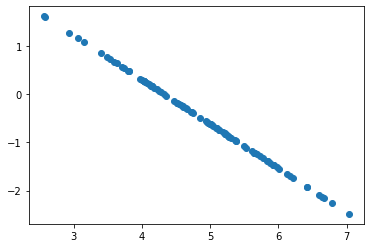

In [146]:
Xdat=x.flatten().reshape(-1,1)
print(Xdat.shape)
print(data_obs_normal.shape)
reg = LinearRegression().fit(Xdat, data_obs_normal)

bc_lr = reg.predict(Xdat)   


plt.scatter(x, bc_lr - x)

array([[1.       , 0.9880097],
       [0.9880097, 1.       ]])

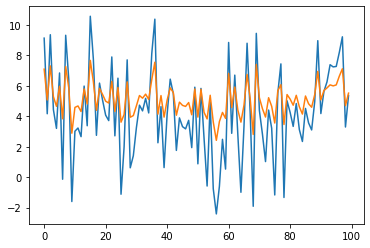

In [126]:
plt.plot(bc_x)
plt.plot(x)
np.corrcoef(bc_x,x)

In [142]:
Xdat=x.flatten().reshape(-1,1)
print(Xdat.shape)
print(data_obs_normal.shape)
reg = LinearRegression().fit(Xdat, data_obs_normal)

bc_lr = reg.predict(x)   


plt.scatter(x, bc_lr - x)

(100, 1)
(100,)


ValueError: Expected 2D array, got 1D array instead:
array=[4.60020483 6.67378043 5.13060796 5.25929293 4.03097645 3.48160858
 3.80381173 5.76754914 5.64817466 4.64060463 3.14990326 4.13339173
 4.93347319 5.84233376 5.02097296 3.73589774 5.60873792 4.07002954
 4.72716814 5.93062001 3.9730298  5.36740633 6.59502311 5.18058873
 5.22053101 4.60637805 4.74238508 6.16215436 4.03226356 4.04056211
 5.37855074 3.81204191 4.14770197 4.1013169  5.68546024 4.21846248
 5.2821709  4.72544541 6.20581526 5.83890815 4.51364247 6.01412609
 6.41202071 5.64794395 5.86997329 5.6634275  5.30727431 6.78919049
 4.99790015 5.73114787 5.97130695 4.00492309 5.28239559 4.03179802
 5.09457646 4.15080047 5.12369107 3.70774762 4.47257254 4.17713843
 4.14862731 4.85501456 5.92676694 6.63763226 5.21524569 3.06629124
 5.53105575 3.62746058 2.93492464 3.588652   3.52605466 5.370683
 4.28221201 4.96835652 5.91794267 5.03367858 5.24573801 7.02637221
 2.57452223 4.03578509 4.51628698 4.57750579 5.4978534  4.13932132
 4.12197758 2.56757854 4.25141643 3.39359429 4.32873106 4.99585518
 4.35663426 5.21218296 6.12406177 5.0087594  5.08789726 4.95372185
 4.54336374 6.42487713 4.65603768 3.8008273 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [49]:
import numpy as np
from sklearn.linear_model import LinearRegression

y = bc_x
X = x.reshape((-1,1))
reg = LinearRegression().fit(X, y)
reg.score(X, y)


# reg.predict()

0.9468051081568126

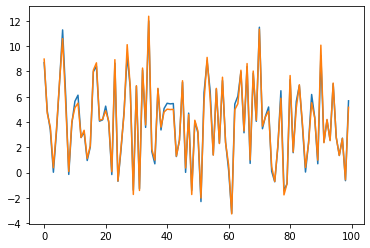

In [41]:
plt.plot(bc_x)
plt.plot(reg.coef_ *x +  reg.intercept_)
